In [5]:
#import libraries 

import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
from scipy.stats import mode
from joblib import Parallel, delayed
from brokenaxes import brokenaxes

In [6]:
#retreive data
fn = '../data/AC_hydrogen_isotopes_duplicate.xlsx'
df = pd.read_excel(fn)

#split dataframe into sample and gdgt
def split_sample_id(df):
    df[['sample', 'gdgt']] = df['sample_id'].str.split('_', expand=True)
    return df
df = split_sample_id(df)

#remove outlier samples
df= df.loc[(df['GDGT'] != 'Cren') | (df['biphytane'] != 'BP-0')]
df = df.loc[(df['GDGT'] != 'G3') | (df['biphytane'] != 'BP-0')]
df = df.loc[(df['sample'] != 'S7') | (df['GDGT'] != 'G0')]
df = df.loc[(df['sample'] != 'S7') | (df['GDGT'] != 'G2')]
condition = ~((df['sample_id'] == 'S1_G2') & (df['biphytane'] == 'BP-0'))
df = df[condition]
df = df.dropna()

#evaluate new df

## Optimization functions for d2H of endmembers and stoichiometry matrix (i.e., biphytane combinations per iGDGT)

In [7]:
# Calculate planktonic contribution from d13C measurements per sample from Keller et al., 2024
def calculate_F_plank(d13C_sample, d13C_meth, d13C_plank):
    F_plank = (d13C_sample - d13C_meth) / (d13C_plank - d13C_meth)
    return F_plank

# Calculate BP distribution using endemmber gdgt distribution results from Keller et al., 2024
def calc_bp_dist(gdgt_distribution, stoichiometry):
    BP_dist = 0.5 * np.dot(gdgt_distribution, stoichiometry)
    return BP_dist

#calculate relative abundances using stoichiometry matrix
def calculate_relative_abundance(stoichiometry):
    normalized_stoichiometry = stoichiometry / 2.0
    columns = ['BP-0', 'BP-1', 'BP-2', 'BP-3', 'BP-4', 'BP-3 (Cren)']
    rows = ['G0', 'G1', 'G2', 'G3', 'G4', 'Cren']
    predicted_abundances_df = pd.DataFrame(normalized_stoichiometry, index=rows, columns=columns)
    return predicted_abundances_df
    
# Map predicted abundances to the original dataframe to do error minimzation 
def map_predicted_abundances(df, predicted_abundances):
    mapped_abundances = []
    for idx, row in df.iterrows():
        gdgt = row['GDGT']
        biphytane = row['biphytane']
        mapped_abundances.append(predicted_abundances.loc[gdgt, biphytane])
    df['predicted_abundance'] = mapped_abundances
    return df

##Penatlies for stiochiometry matrix for continuous values
def penalty_for_rounding(stoichiometry):
    # Define the allowed discrete values
    allowed_values = np.array([0, 0.5, 1, 2])
    penalties = np.min(np.abs(stoichiometry[..., np.newaxis] - allowed_values), axis=-1)
    return np.sum(penalties)
    
# Row sum penalty for stoichiometry; every row of matrix must sum to 2
def row_sum_penalty(stoichiometry, target_sum=2):
    stoichiometry = stoichiometry.reshape(6, 6)
    row_sums = np.sum(stoichiometry, axis=1)
    return np.sum((row_sums - target_sum) ** 2)

#values can only be 0.5, 1, and 2
def penalty_for_continuous_values(stoichiometry):
    allowed_values = np.array([0, 0.5, 1, 2])
    penalty = np.sum(np.min(np.abs(stoichiometry[..., None] - allowed_values), axis=-1) ** 2)
    return penalty

In [8]:
#Calculation of d2H value for each biphytane per sample 
def calculate_d2H_v2(df, d2H_meth, d2H_plank, BP_distribution):
    d2H_values = []
    for idx, row in df.iterrows():
        F_plank_value = row['F_plank']
        bp_index = None

        # Map biphytane to its index
        if row['biphytane'] == 'BP-0':
            bp_index = 0
        elif row['biphytane'] == 'BP-1':
            bp_index = 1
        elif row['biphytane'] == 'BP-2':
            bp_index = 2
        elif row['biphytane'] == 'BP-3':
            bp_index = 3
        elif row['biphytane'] == 'BP-4':
            bp_index = 4
        elif row['biphytane'] == 'BP-3 (Cren)':
            bp_index = 5
        
        if bp_index is not None:
            # Use the same d2H_meth and d2H_plank for all biphytanes
            d2H_BP_plank = d2H_plank
            d2H_BP_meth = d2H_meth
            B_plank = BP_distribution[1, bp_index]
            B_meth = BP_distribution[0, bp_index]

            # Perform general d2H calculation
            denominator = (F_plank_value * B_plank + (1 - F_plank_value) * B_meth)
            if denominator == 0:
                d2H_val = 0
            else:
                d2H_val = (
                    F_plank_value * d2H_BP_plank * B_plank + 
                    (1 - F_plank_value) * d2H_BP_meth * B_meth
                ) / denominator
        else:
            d2H_val = None

        d2H_values.append(d2H_val)

    df['d2H_calculated'] = d2H_values
    return df

In [9]:
## objective function using RMSE for minimization
def objective_function_d2H(params, df, gdgt_distribution):
    d2H_meth, d2H_plank = params[:2]
    stoichiometry = params[2:].reshape(6, 6)  # Work with continuous values

        
    # # # Round stoichiometry to the nearest allowed values (0, 0.5, 1, 2)
    # stoichiometry = np.round(stoichiometry) / 2
    # stoichiometry = np.clip(stoichiometry, 0, 2)
    rounding_penalty = penalty_for_continuous_values(stoichiometry)

    # Mean inferred values from Keller et al., 2024 (Org. Geochem)
    d13C_meth = -98
    d13C_plank = -19
    
    # Calculate biphytane distribution
    BP_distribution = calc_bp_dist(gdgt_distribution, stoichiometry)

    # Make a df copy
    df_with_F = df.copy()

    # Calculate F_plank (i.e., planktonic contribution) from d13C values from Keller et al., 2024 (Org. Geochem)
    df_with_F['F_plank'] = calculate_F_plank(df['d13C'], d13C_meth, d13C_plank)

    # Calculate the predicted d2H values
    df_with_predictions = calculate_d2H_v2(df_with_F, d2H_meth, d2H_plank, BP_distribution)
    
    # Extract observed and predicted values for d2H
    observed_d2H = df_with_predictions['d2H_observed']
    predicted_d2H = df_with_predictions['d2H_calculated']

    # Check for NaN values in predicted d2H
    if np.any(np.isnan(predicted_d2H)):
        print("NaN values found in predicted d2H")
        return np.inf

    # Calculate RMSE for d2H
    rmse_d2H = np.sqrt(np.mean((observed_d2H - predicted_d2H) ** 2))

    # Calculate predicted relative abundances
    predicted_abundances = calculate_relative_abundance(stoichiometry)  # Unrounded stoichiometry
    
    # Map predicted abundances to the original dataframe
    df_with_predictions = map_predicted_abundances(df_with_predictions, predicted_abundances)
    
    # Extract observed and predicted values for relative abundances
    observed_abundances = df_with_predictions['rel_abundance']
    predicted_abundances = df_with_predictions['predicted_abundance']

    # Calculate RMSE for relative abundances
    rmse_abundances = np.sqrt(np.mean((observed_abundances - predicted_abundances) ** 2))

    #normalize rmse
    normalized_rmse_d2h = rmse_d2H / observed_d2H.std()
    normalized_rmse_abundances = rmse_abundances / observed_abundances.std()

    # Combine RMSEs
    total_rmse = rmse_d2H + rmse_abundances

    # Add the penalty for not being close to allowed discrete values (0, 0.5, 1, 2)
    # rounding_penalty_ = penalty_for_rounding(stoichiometry)
    total_rmse += rounding_penalty 
    total_rmse = normalized_rmse_d2h + normalized_rmse_abundances
    total_rmse += row_sum_penalty(stoichiometry)
    
    return total_rmse



In [10]:
# Resampling 
def optimize_bootstrap(sample_indices, df, initial_params, bounds, constraints, gdgt_distribution):
    sample_df = df.iloc[sample_indices].reset_index(drop=True)
    result = minimize(
        objective_function_d2H,
        initial_params,
        args=(df, gdgt_distribution),
        method='L-BFGS-B',
        bounds=bounds,
        # options={'disp': True, 'maxiter': 1000}
)
    return result.x if result.success else None

In [11]:
# Initial parameter guesses
initial_stoichiometry = np.array([
    [2.0, 0, 0.0, 0.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
    [0.5, 1.0, 0.5, 0.0, 0.0, 0.0],
    [0, 1, 1, 0, 0.0, 0.0],
    [0.5, 0.0, 1.0, 0.0, 0.5, 0.0],
    [0, 0, 1.0, 0.0, 0.0, 1.0]
])

initial_d2H_meth_bp0 = -230
initial_d2H_plank_bp0 = -321
# initial_stoichiometry = np.random.uniform(0, 2, (6, 6))
initial_params = np.concatenate(([initial_d2H_meth_bp0, initial_d2H_plank_bp0], initial_stoichiometry.flatten()))

#gdgt distribution from Keller et al., 2024
gdgt_distribution = np.array([[0.31, 0.18, 0.40, 0.06, 0.05, 0.01], #meth 
  [0.46, 0.07, 0.03, 0.00, 0.00, 0.43]]) #plank

In [14]:

#add boundary constrains for reasonable answers
bounds = [(-350, -150), (-350, -150)] + [(0, 2)] * 36

# Bootstrapping and optimization
bootstrap_samples = 50
bootstrap_results = []

constraints = {'type': 'eq', 'fun': lambda x: row_sum_constraint(x[2:])}

#parallel bootstrapping to improve speed
results = Parallel(n_jobs=-1)(delayed(optimize_bootstrap)(np.random.choice(range(len(df)), len(df), replace=True), df,
             initial_params, bounds, constraints,  gdgt_distribution) 
             for _ in range(bootstrap_samples))
bootstrap_results = np.array([res for res in results if res is not None])

# Calculate and print the best parameters and RMSE
best_params = bootstrap_results[np.argmin([objective_function_d2H(params, df, gdgt_distribution) for params in bootstrap_results])]
best_rmse = np.min([objective_function_d2H(params, df,gdgt_distribution) for params in bootstrap_results])
print("Best parameters:", best_params)
print("Best RMSE:", best_rmse)

# Calculate the mode of bootstrap results for each parameter
mode_params = mode(bootstrap_results, axis=0).mode.flatten()
print("Mode of parameters:", mode_params)

# Calculate the median of bootstrap results for each parameter
median_params = np.median(bootstrap_results, axis=0)
print("Median of parameters:", median_params)

Best parameters: [-2.24892450e+02 -3.07455052e+02  2.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  8.41584105e-03
  1.21134315e+00  7.37479473e-01  5.75957081e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.70614264e-01  9.93575647e-01
  4.72640219e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.08504897e-01  9.99945764e-01  0.00000000e+00
  0.00000000e+00  2.93379363e-01  0.00000000e+00  0.00000000e+00
  2.00000000e+00  0.00000000e+00  0.00000000e+00  1.52582394e-03
  6.71759101e-02  0.00000000e+00  1.05129933e+00  0.00000000e+00
  0.00000000e+00  9.07551244e-01]
Best RMSE: 0.49170402912764855
Mode of parameters: [-2.24892450e+02 -3.07455052e+02  2.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  8.41584105e-03
  1.21134315e+00  7.37479473e-01  5.75957081e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.70614264e-01  9.93575647e-01
  4.72640219e-01  0.00000000e+00  0.00000000e+00  0.0

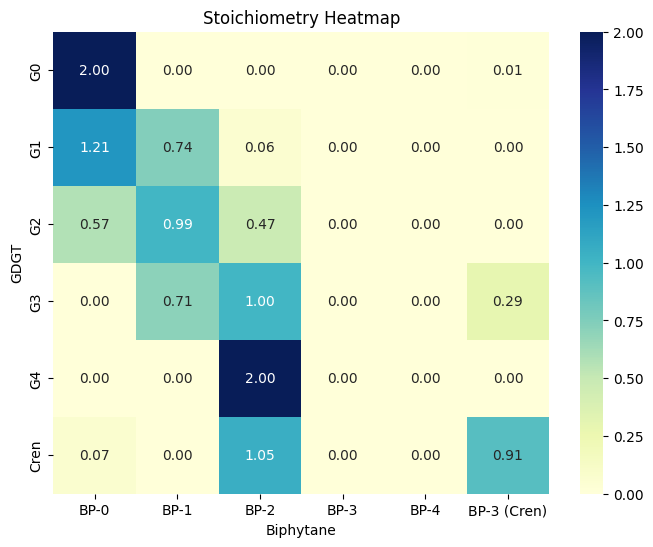

In [15]:
# Extract the stoichiometry part (exclude d2H_meth and d2H_plank)
stoichiometry = best_params[2:].reshape(6, 6)

# Row and column labels for the heatmap
gdgt_labels = ['G0', 'G1', 'G2', 'G3', 'G4', 'Cren']
bp_labels = ['BP-0', 'BP-1', 'BP-2', 'BP-3', 'BP-4', 'BP-3 (Cren)']

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(stoichiometry, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=bp_labels, yticklabels=gdgt_labels)
plt.title("Stoichiometry Heatmap")
plt.xlabel("Biphytane")
plt.ylabel("GDGT")
plt.show()

In [16]:
#calculate CI intervals:
#methane
lower_bounds_meth = np.percentile(bootstrap_results[:, 0], 2.5, axis=0)
upper_bounds_meth  = np.percentile(bootstrap_results[:, 0], 97.5, axis=0)
#plank
lower_bounds_plank = np.percentile(bootstrap_results[:, 1], 2.5, axis=0)
upper_bounds_plank  = np.percentile(bootstrap_results[:, 1], 97.5, axis=0)


print(f'The CI interval for methane cyclin group is {lower_bounds_meth,upper_bounds_meth}')
print(f'The CI interval for planktonic group is {lower_bounds_plank,upper_bounds_plank}')

The CI interval for methane cyclin group is (-224.89244977458463, -224.89244977458463)
The CI interval for planktonic group is (-307.4550523331095, -307.4550523331095)
